In [1]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
#Read all the alerts from file

alerts = pd.read_csv('alerts.csv')
alerts.shape

D:\Tools\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (12,96,98,120,123,234,253,357,367,372,375,550,604,631) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(100000, 640)

In [3]:
#alerts.info(verbose=True)

In [4]:
#These are the interested alerts fields.

alert_fields = ['pn', 'rv81', 'evt', 'sev', 'sun', 'dun', 'iuid', 'tuid', 'iufname', 'tufname', \
                'ttn', 'ttd', 'priority', 'vul', 'sip', 'dip', 'shn', 'dhn', 'sp', 'dp', 'polid', \
                'prot', 'fn', 'rv36', 'tds', 'owner', 'rv29', 'rv30', 'shts', 'thts', 'rv198', 'rv199', \
                'voc', 'xdastaxname', 'xdasoutcomename']

In [5]:
#Reconstruct the alerts with only interested fields and discard other fields.

alerts = alerts[alert_fields]
#alerts.head(3)

In [6]:
#As I know most of the interested field are NaN, lets fill them with specific values.
#Also here it is not completely randomized as the values are mapped

specific_alert_vals = {
    '101': {
        'sev': [0, 2, 4],
        'priority': [20, 50],
        'vul': [0, 1],
        'pn': ['Internal', 'Palo Alto Networks', 'NetIQ Universal Event'], 
        'rv81': ['server', 'laptop'],
        'sun': ['system', 'admin'],
        'dun': ['internal', 'pci-admin'],
        'sip': ['1.0.10.245', '223.113.70.63', '10.84.130.59'],
        'dip': ['10.3.4.51', '10.84.11.14'],
        'shn': ['PERFCDH6', 'Sentinel-Dev-33', 'PERF-SENTINEL'],
        'dhn': ['SOC-LAB-IPV6', 'HostD-03-oracle.com', 'HostD-03-oracle.com'],
        'sp': ['security', 'Windows 7'],
        'dp': ['ASA'],
        'prot': ['tcp', 'udp'],
        'rv36': ['SentinelRESTServices/objects/alert-search', 'SentinelRESTServices/objects/search-terms'],
        'rv29': ['in', 'cn'],
        'rv30': ['us', 'it'],
        'xdastaxname': ['XDAS_AE_CREATE_DATA_ITEM_ASSOC', 'XDAS_AE_QUERY_ACCOUNT'],
        'xdasoutcomename': ['XDAS_OUT_THRESHOLD_EXCEEDED', 'XDAS_OUT_SUCCESS']
    },
    '102': {
        'sev': [1, 3, 4],
        'priority': [80, 100],
        'vul': [0, 1],
        'pn': ['Juniper Netscreen Series', 'Cisco Firewall', 'Damballa Failsafe'], 
        'rv81': ['desktop', 'blade server'],
        'sun': ['internal', 'pci-admin'],
        'dun': ['system', 'admin'],
        'sip': ['164.99.209.149', '164.99.175.32'],
        'dip': ['223.255.254.144', '164.99.175.21', '164.99.175.12'],
        'shn': ['ATL-S-0134294', 'ind-ksatyajit'],
        'dhn': ['HostD-03-oracle.com', 'hoste-01-windows'],
        'sp': ['Windows 7'],
        'dp': ['ThisIsAnOS'],
        'prot': ['http', 'https'],
        'rv36': ['SentinelRESTServices/objects/alert', 'SentinelRESTServices/objects/event-search'],
        'rv29': ['de'],
        'rv30': ['fr', 'jp'],
        'xdastaxname': ['XDAS_AE_TERMINATE_PEER_ASSOC', 'XDAS_AE_QUERY_DATA_ITEM_CONTENTS'],
        'xdasoutcomename': ['XDAS_OUT_FAILURE', 'XDAS_OUT_PRIV_USED']

    },
    '103': {
        'sev': [1, 2, 3],
        'priority': [0, 20],
        'vul': [0, 1],
        'pn': ['Fortinet FortiGate', 'NetIQ Agent Manager'], 
        'rv81': ['switch', 'router', 'rack'],
        'sun': ['service', 'sentinel'],
        'dun': ['pci-admin', 'service'],
        'sip': ['164.99.211.70', '1.0.76.179'],
        'dip': ['164.99.175.41', '23.76.204.168'],
        'shn': ['stl303', 'stl315', 'FW-RedebanWEB'],
        'dhn': ['Sentinel-Dev-06'],
        'sp': ['ASA', 'ThisIsAnOS'],
        'dp': ['dns', 'Windows 7'],
        'prot': ['ftp'],
        'rv36': ['SentinelRESTServices/objects/event-source-server'],
        'rv29': ['us'],
        'rv30': ['uk'],
        'xdastaxname': ['XDAS_AE_DELETE_ACCOUNT', 'XDAS_AE_MODIFY_DATA_ITEM_CONTENTS'],
        'xdasoutcomename': ['XDAS_OUT_SERVICE_UNAVAILABLE', 'XDAS_OUT_HARDWARE_FAILURE', 'XDAS_OUT_DISABLED']
    },
    'A05EF710-5CBE-102E-BEFC-0019D131A0F3': {
        'sev': [2, 3, 4, 5],
        'priority': [20, 50],
        'vul': [0, 1],
        'pn': ['Damballa Failsafe', 'Fortinet FortiGate'], 
        'rv81': ['blade server', 'switch'],
        'sun': ['pci-admin', 'service'],
        'dun': ['service', 'sentinel'],
        'sip': ['1.0.54.201', '1.0.62.233', '10.184.70.34'],
        'dip': ['164.99.175.227'],
        'shn': ['ZF-RCM-41', 'test19390'],
        'dhn': ['adarshiso', 'netflow1'],
        'sp': ['dns'],
        'dp': ['security', 'ASA'],
        'prot': ['smtp', 'dns'],
        'rv36': ['SentinelRESTServices/objects/corr-rule', 'SentinelRESTServices/objects/event-action'],
        'rv29': ['cn', 'de'],
        'rv30': ['it', 'fr'],
        'xdastaxname': ['XDAS_AE_SHUTDOWN_SYS', 'XDAS_AE_BACKUP_DATASTORE', 'XDAS_AE_IDS_PENETRATE'],
        'xdasoutcomename': ['XDAS_OUT_DENIAL', 'XDAS_OUT_EXPIRED']
    },
    'B96F6E09-4DAF-293F-AFEE-B108C842B9E7': {
        'sev': [2, 5],
        'priority': [50, 100],
        'vul': [0, 1],
        'pn': ['NetIQ Universal Event', 'Juniper Netscreen Series'], 
        'rv81': ['laptop', 'desktop'],
        'sun': ['admin', 'internal'],
        'dun': ['internal', 'pci-admin'],
        'sip': ['1.0.76.179', '1.0.54.201'],
        'dip': ['164.99.175.153', '164.99.175.174'],
        'shn': ['FW-RedebanWEB'],
        'dhn': ['stl311', 'stl314'],
        'sp': ['ThisIsAnOS', 'dns'],
        'dp': ['Windows 7', 'ASA'],
        'prot': ['SPX'],
        'rv36': ['SentinelRESTServices/objects/ssdm', 'SentinelRESTServices/objects/collector'],
        'rv29': ['de', 'us'],
        'rv30': ['jp', 'uk'],
        'xdastaxname': ['XDAS_AE_CLEANED', 'XDAS_AE_IDS_SUSPICIOUS', 'XDAS_AE_INFECTED_WORM'],
        'xdasoutcomename': ['XDAS_OUT_UNKNOWN', 'XDAS_OUT_INSUFFICIENT_INPUT', 'XDAS_OUT_ENTITY_EXISTS']
    }
}

def fillSpecificVals():
    step = 20000
    i = 1

    for user, vals in specific_alert_vals.items():
        alerts.loc[np.arange((i-1)*step, i*step), 'owner'] = user

        for attr, val in vals.items():
            alerts.loc[np.arange((i-1)*step, i*step), attr] = np.random.choice(val, step)

        i += 1


In [7]:
#As I know most of the interested field are NaN, lets fill them.
#Here Keep a map of list of values the field can take and randomly fill the alerts with one of values from list

def fillRandomVals():
    pn_vals = ['Internal', 'Palo Alto Networks', 'NetIQ Universal Event', 'Juniper Netscreen Series', \
               'Cisco Firewall', 'Damballa Failsafe', 'Fortinet FortiGate', 'NetIQ Agent Manager']
    alerts['pn'] = np.random.choice(pn_vals, alerts.shape[0])

    rv81_vals = ['server', 'laptop', 'desktop', 'blade server', 'switch', 'router', 'rack']
    alerts['rv81'] = np.random.choice(rv81_vals, alerts.shape[0])

    sev_vals = [0, 1, 2, 3, 4, 5]
    alerts['sev'] = np.random.choice(sev_vals, alerts.shape[0])

    sun_vals = dun_vals = ['system', 'admin', 'internal', 'pci-admin', 'service', 'sentinel']
    alerts['sun'] = np.random.choice(sun_vals, alerts.shape[0])
    alerts['dun'] = np.random.choice(dun_vals, alerts.shape[0])

    priority_vals = [0, 20, 50, 80, 100]
    alerts['priority'] = np.random.choice(priority_vals, alerts.shape[0])

    vul_vals = [0, 1]
    alerts['vul'] = np.random.choice(vul_vals, alerts.shape[0])

    sip_vals = dip_vals = ['1.0.10.245', '223.113.70.63', '10.84.130.59', '164.99.209.149', '164.99.175.32', \
                           '164.99.211.70', '1.0.76.179', '1.0.54.201', '1.0.62.233', '10.184.70.34' \
                           '10.3.4.51', '10.84.11.14', '223.255.254.144', '164.99.175.21', '164.99.175.12', \
                           '164.99.175.41', '23.76.204.168']
    alerts['sip'] = np.random.choice(sip_vals, alerts.shape[0])
    alerts['dip'] = np.random.choice(dip_vals, alerts.shape[0])

    shn_vals = dhn_vals = ['PERFCDH6', 'Sentinel-Dev-33', 'PERF-SENTINEL', 'ATL-S-0134294', 'ind-ksatyajit', \
                           'FW-RedebanWEB' 'ZF-RCM-41', 'test19390', 'SOC-LAB-IPV6', 'HostD-03-oracle.com', \
                           'HostD-03-oracle.com', 'hoste-01-windows']
    alerts['shn'] = np.random.choice(shn_vals, alerts.shape[0])
    alerts['dhn'] = np.random.choice(dhn_vals, alerts.shape[0])

    sp_vals = dp_vals = ['security', 'Windows 7', 'ASA', 'ThisIsAnOS', 'dns']
    alerts['sp'] = np.random.choice(sp_vals, alerts.shape[0])
    alerts['dp'] = np.random.choice(dp_vals, alerts.shape[0])

    prot_vals = ['tcp', 'udp', 'http', 'https', 'ftp', 'smtp', 'dns', 'SPX']
    alerts['prot'] = np.random.choice(prot_vals, alerts.shape[0])

    fn_vals = ['Global Setup', 'Dashboard Status',  'F2107BD0-053D-102D-96EB-001C251476ED']
    alerts['fn'] = np.random.choice(fn_vals, alerts.shape[0])

    rv36_vals = ['SentinelRESTServices/objects/alert-search', 'SentinelRESTServices/objects/search-terms', \
                 'SentinelRESTServices/objects/event-search', 'SentinelRESTServices/objects/event-source-server', \
                 'SentinelRESTServices/objects/corr-rule', 'SentinelRESTServices/objects/event-action']
    alerts['rv36'] = np.random.choice(rv36_vals, alerts.shape[0])

    tds_vals = [0, 10, 12, 15, 20, 100]
    alerts['tds'] = np.random.choice(tds_vals, alerts.shape[0])

    owner_vals = ['1', 'A05EF710-5CBE-102E-BEFC-0019D131A0F3', 'B96F6E09-4DAF-293F-AFEE-B108C842B9E7', '101', '102', \
                  '103', '104', 'A05EF710-5CBE-102E-BEF7-0019D131A0F3', '6E1CCA33-4BD4-102D-B37F-000C2907C76D']
    alerts['owner'] = np.random.choice(owner_vals, alerts.shape[0])

    rv29_vals = rv30_vals = ['in', 'cn', 'de', 'us', 'it', 'fr', 'jp']
    alerts['rv29'] = np.random.choice(rv29_vals, alerts.shape[0])
    alerts['rv30'] = np.random.choice(rv30_vals, alerts.shape[0])

    xdastaxname_vals = ['XDAS_AE_TERMINATE_PEER_ASSOC', 'XDAS_AE_QUERY_DATA_ITEM_CONTENTS', \
                        'XDAS_AE_CREATE_DATA_ITEM_ASSOC', 'XDAS_AE_QUERY_ACCOUNT', 'XDAS_AE_DELETE_ACCOUNT', \
                        'XDAS_AE_MODIFY_DATA_ITEM_CONTENTS', 'XDAS_AE_SHUTDOWN_SYS', 'XDAS_AE_BACKUP_DATASTORE', \
                        'XDAS_AE_IDS_PENETRATE', 'XDAS_AE_CLEANED', 'XDAS_AE_IDS_SUSPICIOUS', 'XDAS_AE_INFECTED_WORM']
    alerts['xdastaxname'] = np.random.choice(xdastaxname_vals, alerts.shape[0])

    xdasoutcomename_vals = ['XDAS_OUT_THRESHOLD_EXCEEDED', 'XDAS_OUT_SUCCESS', 'XDAS_OUT_FAILURE', \
                                       'XDAS_OUT_PRIV_USED', 'XDAS_OUT_SERVICE_UNAVAILABLE', 'XDAS_OUT_HARDWARE_FAILURE', \
                                       'XDAS_OUT_DISABLED', 'XDAS_OUT_DENIAL', 'XDAS_OUT_EXPIRED']
    alerts['xdasoutcomename'] = np.random.choice(xdasoutcomename_vals, alerts.shape[0])


In [8]:
#Not always We get 100% of the data. 
#To simulate the reality, assign some random values to NaN in every column.
#I know sev and priority are always present, this is just a simulation.

def simulateNulls():
    cols_to_null = ['sev', 'priority', 'sun', 'dun']
    for col in cols_to_null:
        alerts.loc[np.random.randint(alerts.shape[0], size=3000), col] = np.NaN

In [9]:
#Name is sufficient to explain

def convertToLower():
    for col in alerts.columns:
        if alerts[col].dtype == np.object:
            alerts[col] = alerts[col].str.lower()

In [10]:
#Cleaning rv36, keep only last segment of 'SentinelRESTServices/objects/event-source-server'

def cleanRv36():
    alerts['rv36'] = alerts['rv36'].str.split('/')
    alerts['rv36'] = [val[len(val)-1] if isinstance(val, list) else val for val in alerts['rv36']]

In [11]:
#Filling NaN in Vul

def fillVul():
    if alerts['vul'].isnull().sum() > 0:
        alerts['vul'].fillna(alerts['vul'].min(), inplace=True)

In [12]:
#From here onwrds begins
    #Data generation
    #Data cleaning
    #Filling NaN

fillSpecificVals()
#fillRandomVals()

simulateNulls()
convertToLower()

cleanRv36()
fillVul()

In [13]:
#As evt is more of a arbitrary string and does not add value, lets drop the column

if 'evt' in alerts.columns:
    alerts.drop(['evt'], axis=1, inplace=True)

In [14]:
#So Let me check how many columns contain null values and what is the precentage of null in each column

alerts.isnull().sum()/alerts.shape[0]*100

pn                   0.000
rv81                 0.000
sev                  2.952
sun                  2.961
dun                  2.955
iuid                99.999
tuid               100.000
iufname            100.000
tufname            100.000
ttn                100.000
ttd                100.000
priority             2.960
vul                  0.000
sip                  0.000
dip                  0.000
shn                  0.000
dhn                  0.000
sp                   0.000
dp                   0.000
polid              100.000
prot                 0.000
fn                 100.000
rv36                 0.000
tds                100.000
owner                0.000
rv29                 0.000
rv30                 0.000
shts               100.000
thts               100.000
rv198              100.000
rv199              100.000
voc                100.000
xdastaxname          0.000
xdasoutcomename      0.000
dtype: float64

In [15]:
#Lets keep a threshold of 90%. Whichever column has 90% nulls, drop them as they may not add any value.

valid_cols = [col for col in alerts.columns if (alerts[col].isnull().sum()/alerts.shape[0]*100 < 90)]
alerts = alerts[valid_cols]
alerts.head(3)

,pn,rv81,sev,sun,dun,priority,vul,sip,dip,shn,dhn,sp,dp,prot,rv36,owner,rv29,rv30,xdastaxname,xdasoutcomename
0,internal,server,0.0,NaN,internal,NaN,0,223.113.70.63,10.3.4.51,perf-sentinel,hostd-03-oracle.com,security,asa,tcp,search-terms,101,in,us,xdas_ae_create_data_item_assoc,xdas_out_success
1,netiq universal event,laptop,4.0,system,internal,50.0,1,223.113.70.63,10.3.4.51,sentinel-dev-33,hostd-03-oracle.com,security,asa,udp,search-terms,101,in,it,xdas_ae_create_data_item_assoc,xdas_out_threshold_exceeded
2,netiq universal event,laptop,4.0,system,internal,50.0,1,10.84.130.59,10.84.11.14,perfcdh6,hostd-03-oracle.com,windows 7,asa,tcp,alert-search,101,cn,it,xdas_ae_query_account,xdas_out_threshold_exceeded


In [16]:
'''
Group all xdastaxname without the actual operation in the name.
    i.e XDAS_AE_CREATE_ACCOUNT, XDAS_AE_DELETE_ACCOUNT, XDAS_AE_DISABLE_ACCOUNT etc all belong to ACCOUNT type.
    So clean the taxonomy name
'''

#alerts['xdastaxname_new'] = alerts['xdastaxname'].str.strip('XDAS_AE_')
#alerts['xdastaxname_new']

'\nGroup all xdastaxname without the actual operation in the name.\n    i.e XDAS_AE_CREATE_ACCOUNT, XDAS_AE_DELETE_ACCOUNT, XDAS_AE_DISABLE_ACCOUNT etc all belong to ACCOUNT type.\n    So clean the taxonomy name\n'

In [17]:
#Check the columns and null percentage after removing unwanted columns

alerts.isnull().sum()/alerts.shape[0]*100

pn                 0.000
rv81               0.000
sev                2.952
sun                2.961
dun                2.955
priority           2.960
vul                0.000
sip                0.000
dip                0.000
shn                0.000
dhn                0.000
sp                 0.000
dp                 0.000
prot               0.000
rv36               0.000
owner              0.000
rv29               0.000
rv30               0.000
xdastaxname        0.000
xdasoutcomename    0.000
dtype: float64

In [18]:
#Having a look at numerical values.

alerts.describe()

,sev,priority,vul
count,97048.000000,97040.000000,100000.000000
mean,2.735584,49.079555,0.503080
std,1.458844,33.358748,0.499993
min,0.000000,0.000000,0.000000
25%,2.000000,20.000000,0.000000
50%,3.000000,50.000000,1.000000
75%,4.000000,80.000000,1.000000
max,5.000000,100.000000,1.000000


D:\Tools\Anaconda\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


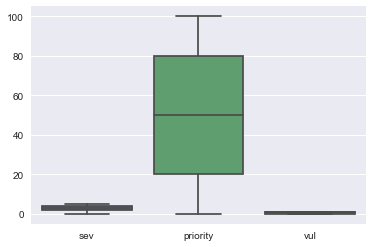

In [19]:
#Boxplot to check if there are any outliers

sns.boxplot(alerts.select_dtypes(exclude=[np.object]))

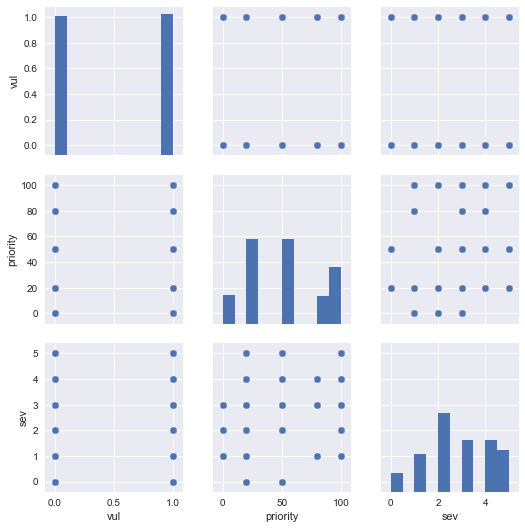

In [20]:
#See if there is a collinearity

sns.pairplot(alerts[['vul', 'priority', 'sev']].dropna())

In [21]:
#How categorical and string data are distributed

alerts.describe(include=['O'])

,pn,rv81,sun,dun,sip,dip,shn,dhn,sp,dp,prot,rv36,owner,rv29,rv30,xdastaxname,xdasoutcomename
count,100000,100000,97039,97045,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
unique,8,7,6,6,10,10,10,8,5,5,8,9,5,4,5,12,12
top,fortinet fortigate,blade server,pci-admin,pci-admin,1.0.76.179,164.99.175.227,fw-redebanweb,hostd-03-oracle.com,dns,asa,spx,event-source-server,103,de,uk,xdas_ae_delete_account,xdas_out_denial
freq,19969,20123,19713,29021,20020,20000,26706,23287,30088,39845,20000,20000,20000,40021,29932,10166,10026


In [22]:
#alerts.head(3)

In [23]:
#Nothing much, just how owners of alerts have handled alerts pertaining to specific zone/region?

pd.crosstab(alerts['owner'], alerts['rv30'])

rv30,fr,it,jp,uk,us
owner,,,,,
101,0,9945,0,0,10055
102,10037,0,9963,0,0
103,0,0,0,20000,0
a05ef710-5cbe-102e-befc-0019d131a0f3,9913,10087,0,0,0
b96f6e09-4daf-293f-afee-b108c842b9e7,0,0,10068,9932,0


In [24]:
#How owners of alerts have handled alerts pertaining to specific host types?

pd.crosstab(alerts['owner'], alerts['rv81'])

rv81,blade server,desktop,laptop,rack,router,server,switch
owner,,,,,,,
101,0,0,10008,0,0,9992,0
102,9905,10095,0,0,0,0,0
103,0,0,0,6598,6778,0,6624
a05ef710-5cbe-102e-befc-0019d131a0f3,10218,0,0,0,0,0,9782
b96f6e09-4daf-293f-afee-b108c842b9e7,0,9898,10102,0,0,0,0


In [25]:
def predictMissingCol(colName):
    if alerts[colName].isnull().sum() > 0:

        #Fields used to predict the null values of given column
        desired_cols = ['vul', 'pn', 'sun', 'dun', 'sip', 'dip', 'sev', 'priority']

        X_train = alerts[desired_cols].copy()
        X_test = alerts[desired_cols][alerts[colName].isnull()].copy()

        X_train.dropna(axis=0, inplace=True)
        y_train = X_train[colName]

        for col in X_train.columns:
            if col != colName:
                #No need to remove a column for dummies as it is not regression
                #X_test = X_test.join(pd.get_dummies(X_test[col], prefix=col).iloc[:, :-1])
                X_train = X_train.join(pd.get_dummies(X_train[col], prefix=col))
                X_test = X_test.join(pd.get_dummies(X_test[col], prefix=col))

        X_train.drop(desired_cols, axis=1, inplace=True)
        X_test.drop(desired_cols, axis=1, inplace=True)

        clf_model = RandomForestClassifier()
        clf_model = clf_model.fit(X_train, y_train)

        print ('%s prediction score: %f' % (colName, clf_model.score(X_train, y_train)))

        y_pred = clf_model.predict(X_test)
        alerts[colName][alerts[colName].isnull()] = y_pred
        print ('Predicted %d null values for %s column.' % (y_pred.shape[0], colName))
        print ()


In [26]:
#Predict the suitable values for nulls to be filled based on the available information

predictMissingCol('sev')
predictMissingCol('sun')
predictMissingCol('dun')
predictMissingCol('priority')

sev prediction score: 0.394497
Predicted 2952 null values for sev column.

sun prediction score: 0.551401
Predicted 2961 null values for sun column.

dun prediction score: 0.556548
Predicted 2955 null values for dun column.

priority prediction score: 0.561078
Predicted 2960 null values for priority column.



In [27]:
#Confirm all NaN are filled

alerts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
pn                 100000 non-null object
rv81               100000 non-null object
sev                100000 non-null float64
sun                100000 non-null object
dun                100000 non-null object
priority           100000 non-null float64
vul                100000 non-null int64
sip                100000 non-null object
dip                100000 non-null object
shn                100000 non-null object
dhn                100000 non-null object
sp                 100000 non-null object
dp                 100000 non-null object
prot               100000 non-null object
rv36               100000 non-null object
owner              100000 non-null object
rv29               100000 non-null object
rv30               100000 non-null object
xdastaxname        100000 non-null object
xdasoutcomename    100000 non-null object
dtypes: float64(2), int64(1), object(17)
memory u

In [28]:
#Before getting ahead, we need to chanage columns to proper dtype.

'''
alerts['pn'] = pd.Categorical(alerts['pn'])
alerts['rv81'] = pd.Categorical(alerts['rv81'])
alerts['sev'] = pd.Categorical(alerts['sev'], categories=[0, 1, 2, 3, 4, 5], ordered=True)
alerts['sun'] = pd.Categorical(alerts['sun'])
alerts['dun'] = pd.Categorical(alerts['dun'])
alerts['priority'] = pd.Categorical(alerts['priority'], categories=[0, 20, 50, 80, 100], ordered=True)
alerts['vul'] = pd.Categorical(alerts['vul'], categories=[0, 1])
alerts['sip'] = pd.Categorical(alerts['sip'])
alerts['dip'] = pd.Categorical(alerts['dip'])
alerts['shn'] = pd.Categorical(alerts['shn'])
alerts['dhn'] = pd.Categorical(alerts['dhn'])
alerts['sp'] = pd.Categorical(alerts['sp'])
alerts['dp'] = pd.Categorical(alerts['dp'])
alerts['prot'] = pd.Categorical(alerts['prot'])
alerts['fn'] = pd.Categorical(alerts['fn'])
alerts['rv36'] = pd.Categorical(alerts['rv36'])
alerts['tds'] = pd.Categorical(alerts['tds'])
alerts['rv29'] = pd.Categorical(alerts['rv29'])
alerts['rv30'] = pd.Categorical(alerts['rv30'])
alerts['xdastaxname'] = pd.Categorical(alerts['xdastaxname'])
alerts['xdasoutcomename'] = pd.Categorical(alerts['xdasoutcomename'])
'''

def convertToCategorical():
    for col in alerts.columns:
        if col == 'sev':
            alerts['sev'] = pd.Categorical(alerts['sev'], categories=[0, 1, 2, 3, 4, 5], ordered=True)
        elif col == 'priority':
            alerts['priority'] = pd.Categorical(alerts['priority'], categories=[0, 20, 50, 80, 100], ordered=True)
        elif col == 'vul':
            alerts['vul'] = pd.Categorical(alerts['vul'], categories=[0, 1])
        else:
            alerts[col] = pd.Categorical(alerts[col])

#convertToCategorical()

In [29]:
#Convert categorical columns to OneHotEncoding

def colsToDummies(tmp_alerts):
    X = pd.DataFrame()

    for col in tmp_alerts.columns:
        if (tmp_alerts[col].dtype == np.object):
            X = pd.concat([X, pd.get_dummies(tmp_alerts[col], prefix=col)], axis=1)
        elif (tmp_alerts[col].dtype != np.object):
            X = pd.concat([X, tmp_alerts[col]], axis=1)

    return X


In [30]:
#Categoricals to numerical encoding but each column having its own encoder.

def colsIndependentLabelEncode(tmp_alerts):
    X = tmp_alerts.select_dtypes(include=[np.object]).copy()

    X = X.apply(LabelEncoder().fit_transform)
    X = pd.concat([X, tmp_alerts.select_dtypes(exclude=[np.object])], axis=1)

    return X

In [31]:
#Convert categorical columns to numerical encoding
#One encoder for sip/dip, shn/dhn etc pair

def colsLabelEncode(tmp_alerts):
    X = pd.DataFrame()
    le_dict = {}

    for col in tmp_alerts.columns:
        if col in ['sun', 'dun']:
            if 'user_name' not in le_dict:
                le_dict['user_name'] = LabelEncoder()
                le_dict['user_name'].fit(pd.unique(tmp_alerts[['sun', 'dun']].values.ravel()))
                X[col] = le_dict['user_name'].transform(tmp_alerts[col])
            else:
                X[col] = le_dict['user_name'].transform(tmp_alerts[col])
        elif col in ['sip', 'dip']:
            if 'ip' not in le_dict:
                le_dict['ip'] = LabelEncoder()
                le_dict['ip'].fit(pd.unique(tmp_alerts[['sip', 'dip']].values.ravel()))
                X[col] = le_dict['ip'].transform(tmp_alerts[col])
            else:
                X[col] = le_dict['ip'].transform(tmp_alerts[col])
        elif col in ['shn', 'dhn']:
            if 'host_name' not in le_dict:
                le_dict['host_name'] = LabelEncoder()
                le_dict['host_name'].fit(pd.unique(tmp_alerts[['shn', 'dhn']].values.ravel()))
                X[col] = le_dict['host_name'].transform(tmp_alerts[col])
            else:
                X[col] = le_dict['host_name'].transform(tmp_alerts[col])
        elif col in ['sp', 'dp']:
            if 'process' not in le_dict:
                le_dict['process'] = LabelEncoder()
                le_dict['process'].fit(pd.unique(tmp_alerts[['sp', 'dp']].values.ravel()))
                X[col] = le_dict['process'].transform(tmp_alerts[col])
            else:
                X[col] = le_dict['process'].transform(tmp_alerts[col])
        elif col in ['rv29', 'rv30']:
            if 'host_country' not in le_dict:
                le_dict['host_country'] = LabelEncoder()
                le_dict['host_country'].fit(pd.unique(tmp_alerts[['rv29', 'rv30']].values.ravel()))
                X[col] = le_dict['host_country'].transform(tmp_alerts[col])
            else:
                X[col] = le_dict['host_country'].transform(tmp_alerts[col])
        else:
            if tmp_alerts[col].dtype == np.object:
                le_dict[col] = LabelEncoder()
                X[col] = le_dict[col].fit_transform(tmp_alerts[col])
            else:
                X = pd.concat([X, tmp_alerts[col]], axis=1)

    return X    


In [32]:
def createXy(colName, ohOrEncode='encode'):

    #Get the output variable separate
    y = alerts[colName].copy()

    #unwanted_cols = ['dun', 'dip', 'dhn', 'dp', 'sp', 'fn', 'tds', 'rv30']
    #final_alerts = alerts.drop(unwanted_cols, axis=1)

    #For testing purpose: Creating copy as not to loose all the transformations applied on original alerts.
    final_alerts = alerts.copy()
    final_alerts.drop(colName, axis=1, inplace=True)

    if (ohOrEncode == 'encode'):
        X = colsLabelEncode(final_alerts)
    elif (ohOrEncode == 'dummies'):
        X = colsToDummies(final_alerts)
    elif (ohOrEncode == 'independentLabel-encode'):
        X = colsIndependentLabelEncode(final_alerts)

    return (X, y)

In [33]:
def predict(colName, ohOrEncode='encode'):
    X, y = createXy(colName, ohOrEncode=ohOrEncode)

    print ('X contains rows/cols: ', X.shape)
    print ('X columns: ', X.columns)
    #print (X.head(3))

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    #fold = KFold(n_splits=3, random_state=0)
    split = StratifiedKFold(n_splits=5)

    rf = RandomForestClassifier(n_estimators=10)
    ada = AdaBoostClassifier(n_estimators=10)
    gb = GradientBoostingClassifier(n_estimators=10)
    xtra_tree = ExtraTreesClassifier()
    dec_tree = DecisionTreeClassifier()
    knn = KNeighborsClassifier()

    classifiers = {
        'rf': rf,
        'ada': ada,
        'gb': gb
        #'xtra_tree': xtra_tree
        #'dec_tree': dec_tree
        #'knn' : knn
    }

    t0 = time()
    cv_mean_scores = []
    for clf_name, clf in classifiers.items():
        cv_score = cross_val_score(clf, X_train, y_train, cv=split)
        cv_mean_scores.append(cv_score.mean()*100)

    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_pred_prob = rf.predict_proba(X_test)
    y_pred_log_prob = rf.predict_log_proba(X_test)

    print ()
    print("took %0.3fs." % (time() - t0))
    print ()

    print ('cross validation score of each classifier: ', cv_mean_scores)
    print ('--'*35)
    print ('confusion_matrix of RandomForest classifier')
    print ()
    print (confusion_matrix(y_pred=y_pred, y_true=y_test))
    print ('--'*35)

    sns.barplot(list(classifiers.keys()), cv_mean_scores)

X contains rows/cols:  (100000, 19)
X columns:  Index(['pn', 'rv81', 'sev', 'sun', 'dun', 'priority', 'vul', 'sip', 'dip',
       'shn', 'dhn', 'sp', 'dp', 'prot', 'rv36', 'rv29', 'rv30', 'xdastaxname',
       'xdasoutcomename'],
      dtype='object')

took 24.653s.

cross validation score of each classifier:  [100.0, 80.04933344017778, 100.0]
----------------------------------------------------------------------
confusion_matrix of RandomForest classifier

[[5000    0    0    0    0]
 [   0 5037    0    0    0]
 [   0    0 5000    0    0]
 [   0    0    0 4930    0]
 [   0    0    0    0 5033]]
----------------------------------------------------------------------


D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:628: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


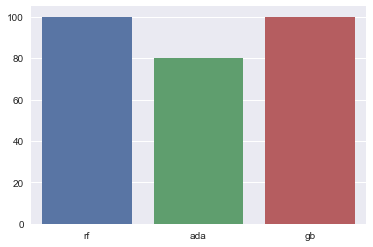

In [34]:
#Lets predict the owner for test data based on the learning on training data

predict('owner', ohOrEncode='encode')

X contains rows/cols:  (100000, 19)
X columns:  Index(['pn', 'rv81', 'sev', 'sun', 'dun', 'vul', 'sip', 'dip', 'shn', 'dhn',
       'sp', 'dp', 'prot', 'rv36', 'owner', 'rv29', 'rv30', 'xdastaxname',
       'xdasoutcomename'],
      dtype='object')

took 21.658s.

cross validation score of each classifier:  [50.47866524806498, 49.93734693285935, 49.74267173195857]
----------------------------------------------------------------------
confusion_matrix of RandomForest classifier

[[1352 1116    0    0    0]
 [1376 4149 2023    0    0]
 [   0 2915 3504    0 1022]
 [   0    0    0 1428 1074]
 [   0    0 1438 1374 2229]]
----------------------------------------------------------------------


D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:628: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


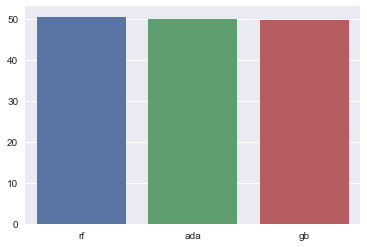

In [35]:
#Lets predict the owner for test data based on the learning on training data

predict('priority', ohOrEncode='encode')

In [36]:
#Tuning RandomForest hyper parameters

'''
gs_rf_params = [{
    'n_estimators':[50, 100, 150],
    'criterion': ['entropy', 'gini'],
    'max_features':[5, 'auto', 'log2'],
    'min_samples_split':[5, 10, 15],
    'min_samples_leaf':[2],
    'bootstrap' : [True, False], 
    'n_jobs':[-1],
    'oob_score':[True],
    'warm_start': [True, False]
}]

gs_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=gs_rf_params, cv=split)
gs_rf.fit(X_train, y_train)

rf_best_params = gs_rf.best_params_
rf_best_score = gs_rf.best_score_
rf_best = gs_rf.best_estimator_

print (rf_best_params)
print (rf_best_score)
print (rf_best)
'''

"\ngs_rf_params = [{\n    'n_estimators':[50, 100, 150],\n    'criterion': ['entropy', 'gini'],\n    'max_features':[5, 'auto', 'log2'],\n    'min_samples_split':[5, 10, 15],\n    'min_samples_leaf':[2],\n    'bootstrap' : [True, False], \n    'n_jobs':[-1],\n    'oob_score':[True],\n    'warm_start': [True, False]\n}]\n\ngs_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=gs_rf_params, cv=split)\ngs_rf.fit(X_train, y_train)\n\nrf_best_params = gs_rf.best_params_\nrf_best_score = gs_rf.best_score_\nrf_best = gs_rf.best_estimator_\n\nprint (rf_best_params)\nprint (rf_best_score)\nprint (rf_best)\n"